<a href="https://colab.research.google.com/github/JohnnyMinx/JohnnyMinx/blob/main/IndProject_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import openpyxl
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_excel('/content/ZTE Corp Price History.xlsx')

In [ ]:
# Function to calculate RSI
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate EMA
def calculate_ema(data, span):
    ema = data.ewm(span=span, adjust=False).mean()
    return ema

# Sorting the data by 'Exchange Date'
df['Exchange Date'] = pd.to_datetime(df['Exchange Date'])
df_sorted = df.sort_values(by='Exchange Date')

# Adding extra financial indicators RSI and EMA to the DataFrame
df_sorted['RSI'] = calculate_rsi(df_sorted['Close'])
df_sorted['EMA_12'] = calculate_ema(df_sorted['Close'], 12)
df_sorted['EMA_26'] = calculate_ema(df_sorted['Close'], 26)

# Shift 'Close' to get 'Next Day Close'
df_sorted['Next Day Close'] = df_sorted['Close'].shift(-1)

# Handling NaN values resulting from the calculations
df_sorted.dropna(inplace=True)

# Split the dataset
train_size = 0.8
test_size = 0.1
val_size = 0.1

total_samples = len(df_sorted)
train_end_idx = int(total_samples * train_size)
test_end_idx = train_end_idx + int(total_samples * test_size)

train_data = df_sorted.iloc[:train_end_idx]
test_data = df_sorted.iloc[train_end_idx:test_end_idx]
val_data = df_sorted.iloc[test_end_idx:]

# Update features list to include RSI and EMA
features = ['Close', 'Open', 'Low', 'High', 'Volume', 'RSI', 'EMA_12', 'EMA_26']
target = 'Next Day Close'

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))

train_features = scaler.fit_transform(train_data[features])
test_features = scaler.transform(test_data[features])
val_features = scaler.transform(val_data[features])

train_target = train_data[target].values
test_target = test_data[target].values
val_target = val_data[target].values

# Function to create sequences for the GRU model
def create_sequences(features, target, time_steps=1):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

# Set the number of time steps
time_steps = 5

# Create sequences
X_train, y_train = create_sequences(train_features, train_target, time_steps)
X_test, y_test = create_sequences(test_features, test_target, time_steps)
X_val, y_val = create_sequences(val_features, val_target, time_steps)

# Building the GRU model with additional layers and dropouts
model = Sequential()
model.add(GRU(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'))
model.add(Dropout(0.1))  # Adding 10% dropout to prevent overfitting
model.add(GRU(units=128, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))  # Adding 20% dropout to prevent overfitting
model.add(GRU(units=256, activation='tanh'))
model.add(Dropout(0.3))  # Adding 30% dropout to prevent overfitting
model.add(Dense(units=1))

# Compiling the model with Huber loss function
model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber())

# Defining early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)

# Evaluating the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss}')

# Making predictions
y_pred = model.predict(X_test)

# Reshaping y_test and y_pred to 1D arrays for easier comparison
y_test = y_test.reshape(-1)
y_pred = y_pred.reshape(-1)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 0.7215 - val_loss: 0.0257
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0401 - val_loss: 0.0195
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0367 - val_loss: 0.0184
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0339 - val_loss: 0.0182
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0357 - val_loss: 0.0196
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0348 - val_loss: 0.0282
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0304 - val_loss: 0.0202
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0333 - val_loss: 0.0240
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0330 - val_loss: 0.0182
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0343 - val_loss: 0.0298
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0331 - val_loss: 0.0369
Epoch 12/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/ste

In [ ]:
# Evaluating the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss}')

Test Loss: 0.006250962149351835


In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)
print(f'R-squared Score: {r2}')

RMSE: 0.1118119940932974
R-squared Score: 0.9227255900906605


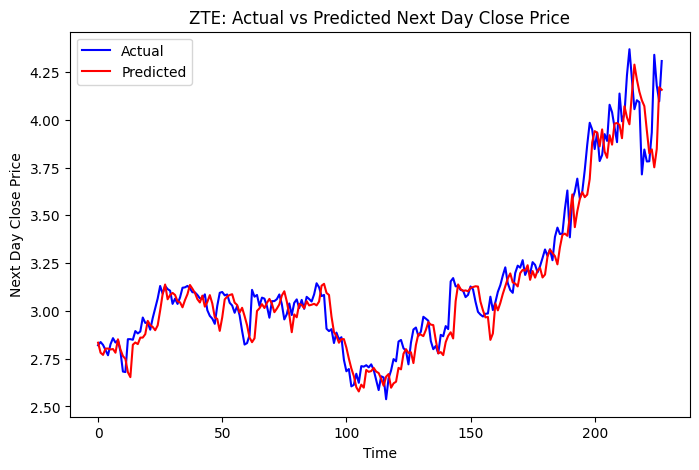

In [ ]:
# Plotting original actual vs predicted next day close prices without smoothing
plt.figure(figsize=(8, 5))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title('ZTE: Actual vs Predicted Next Day Close Price')
plt.xlabel('Time')
plt.ylabel('Next Day Close Price')
plt.legend()
plt.show()

In [ ]:
threshold = 0.05  # Can be Increased or Decreased threshold
stop_loss_threshold = 0.05  # 5% stop-loss
take_profit_threshold = 0.10  # 10% take-profit

# Generating the buy/sell signals
signals = np.where((y_pred[1:] - y_pred[:-1]) > threshold, 1, np.where((y_pred[1:] - y_pred[:-1]) < -threshold, -1, 0))

# Backtesting the strategy
initial_balance = 10000
balance = initial_balance
shares = 0

buy_signals = []
sell_signals = []

for i in range(len(signals)):
    if signals[i] == 1:  # Buy signal
        if balance > 0:
            buy_signals.append(i)
            shares = balance / y_test[i]
            balance = 0
    elif signals[i] == -1 and shares > 0:  # Sell signal
        sell_signals.append(i)
        balance = shares * y_test[i]
        shares = 0
    elif shares > 0:  # Apply stop-loss or take-profit
        if y_test[i] < y_test[buy_signals[-1]] * (1 - stop_loss_threshold):  # Stop-loss
            sell_signals.append(i)
            balance = shares * y_test[i]
            shares = 0
        elif y_test[i] > y_test[buy_signals[-1]] * (1 + take_profit_threshold):  # Take-profit
            sell_signals.append(i)
            balance = shares * y_test[i]
            shares = 0

# Calculate final balance
final_balance = balance + shares * y_test[-1]  # Account for any remaining shares

print(f'Initial Balance: ${initial_balance}')
print(f'Final Balance: ${final_balance}')

# Performance improvement
improvement = (final_balance - initial_balance) / initial_balance * 100
print(f'Performance Improvement: {improvement:.2f}%')


Initial Balance: $10000
Final Balance: $11154.811741821211
Performance Improvement: 11.55%


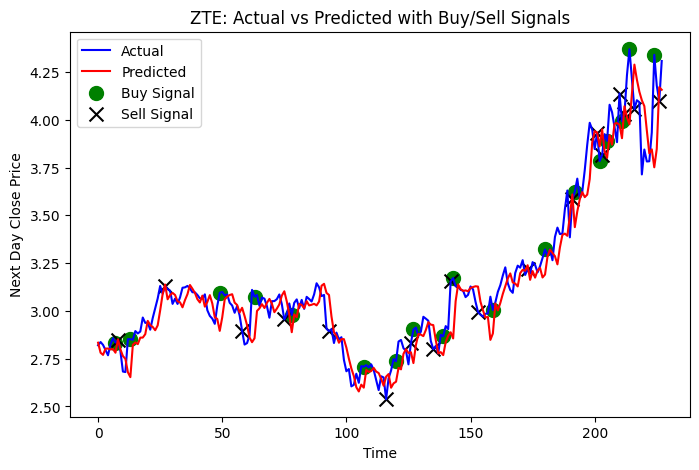

In [ ]:
# Plotting buy/sell signals on the original graph
plt.figure(figsize=(8, 5))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.scatter(buy_signals, y_test[buy_signals], color='green', marker='o', label='Buy Signal', s=100)
plt.scatter(sell_signals, y_test[sell_signals], color='black', marker='x', label='Sell Signal', s=100)
plt.title('ZTE: Actual vs Predicted with Buy/Sell Signals')
plt.xlabel('Time')
plt.ylabel('Next Day Close Price')
plt.legend()
plt.show()

In [ ]:
# Generating buy/sell signals with a threshold
threshold = 0.01  # Example threshold for significant price movement
signals = np.where((y_pred[1:] - y_pred[:-1]) > threshold, 1, np.where((y_pred[1:] - y_pred[:-1]) < -threshold, -1, 0))

# Backtesting the strategy
initial_balance = 10000
balance = initial_balance
shares = 0

buy_signals = []
sell_signals = []

for i in range(len(signals)):
    if signals[i] == 1:  # Buy signal
        if balance > 0:
            buy_signals.append(i)
            shares = balance / y_test[i]
            balance = 0
    elif signals[i] == -1 and shares > 0:  # Sell signal
        sell_signals.append(i)
        balance = shares * y_test[i]
        shares = 0

# Calculate final balance
final_balance = balance + shares * y_test[-1]  # Account for any remaining shares

print(f'Initial Balance: ${initial_balance}')
print(f'Final Balance: ${final_balance}')

# Performance improvement
improvement = (final_balance - initial_balance) / initial_balance * 100
print(f'Performance Improvement: {improvement:.2f}%')

Initial Balance: $10000
Final Balance: $10924.017422219782
Performance Improvement: 9.24%


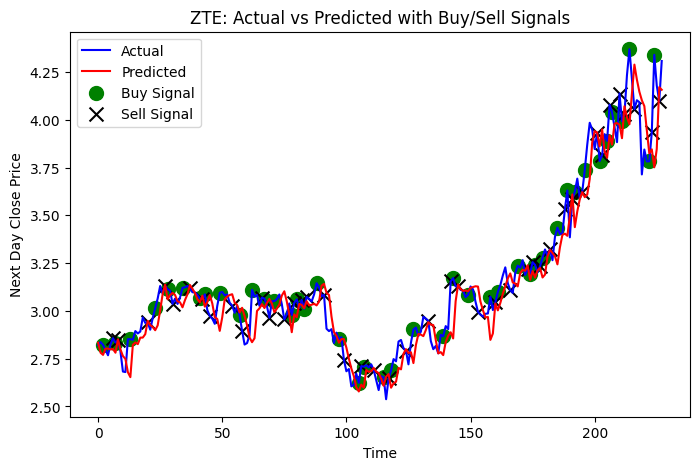

In [ ]:
# Plotting buy/sell signals on the original graph
plt.figure(figsize=(8, 5))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.scatter(buy_signals, y_test[buy_signals], color='green', marker='o', label='Buy Signal', s=100)
plt.scatter(sell_signals, y_test[sell_signals], color='black', marker='x', label='Sell Signal', s=100)
plt.title('ZTE: Actual vs Predicted with Buy/Sell Signals')
plt.xlabel('Time')
plt.ylabel('Next Day Close Price')
plt.legend()
plt.show()